+ a simple autoencoder based on a fully-connected layer
+ a sparse autoencoder
+ a deep fully-connected autoencoder
+ a deep convolutional autoencoder
+ an image denoising model
+ a sequence-to-sequence autoencoder
+ a variational autoencoder

<img src="Images/Enocoder.png">

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 

+ 1) data-specific, 

+ 2) lossy, and 

+ 3) learned automatically from examples rather than engineered by a human. 

To build an autoencoder, you need three things: 

+ an encoding function, 
+ a decoding function,
+ distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

What are autoencoders good for?
They are rarely used in practical applications. In 2012 they briefly found an application in greedy layer-wise pretraining for deep convolutional neural networks [1], but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. In 2014, batch normalization [2] started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning [3].

Today two interesting practical applications of autoencoders are 

+ 1. data denoising (which we feature later in this post), 
+ 2. dimensionality reduction for data visualization.

With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

In self-supervized learning applied to vision, a potentially fruitful alternative to autoencoder-style input reconstruction is the use of toy tasks such as jigsaw puzzle solving, or detail-context matching (being able to match high-resolution but small patches of pictures with low-resolution versions of the pictures they are extracted from). The following paper investigates jigsaw puzzle solving and makes for a very interesting read: Noroozi and Favaro (2016) Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles. Such tasks are providing the model with built-in assumptions about the input data which are missing in traditional autoencoders, such as "visual macro-structure matters more than pixel-level details".

## Simple Auto Encoder

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [3]:
# thisis the size of our encoded representations
encoding_dim = 32 # 

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded rep of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

#"decoded is the lossy reconstruction of the input"
decoded = Dense(784, activation='sigmoid')(encoded)


#this model maps an input to its encoded rep
encoder = Model(input_img, encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
# create a placehoder for an encoded (32-dim) input
encoded_input = Input(shape=(encoding_dim,))

# retrive the last of the autencoder model
decoder_layer = autoencoder.layers[-1]
all_layer = autoencoder.layers

#create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
# Let's prepare our input data. Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

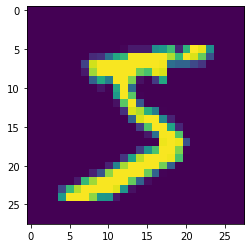

In [7]:
plt.imshow(x_train[0,:,:])

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
autoencoder.fit(x_train, x_train,
               epochs=50, 
               batch_size = 256,
               shuffle=True,
               validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.3714 - val_loss: 0.2708
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2635 - val_loss: 0.2524
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2413 - val_loss: 0.2283
Epoch 4/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.2199 - val_loss: 0.2097
Epoch 5/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.2046 - val_loss: 0.1972
Epoch 6/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.1942 - val_loss: 0.1883
Epoch 7/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1862 - val_loss: 0.1812
Epoch 8/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1797 - val_loss: 0.1754
Epoch 9/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1741 - val_loss: 0.1701
Epoch

In [11]:
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']

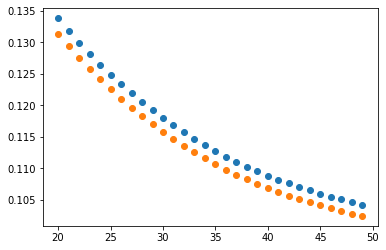

In [12]:
plt.scatter(autoencoder.history.epoch[20:],train_loss[20:])
plt.scatter(autoencoder.history.epoch[20:],val_loss[20:])

In [13]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

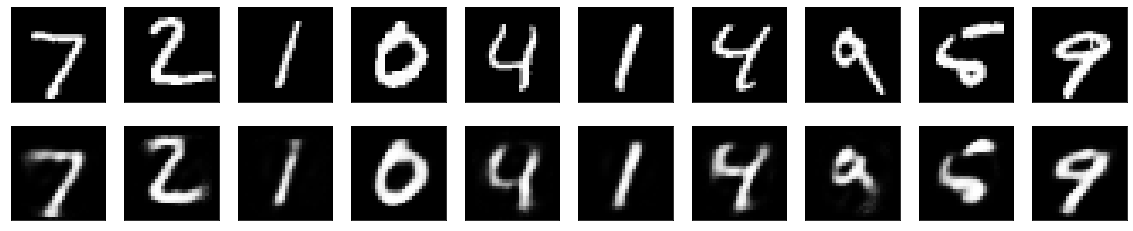

In [14]:
n = 10
plt.figure(figsize=(20 ,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
encoded_imgs[0]

array([ 3.7831326 ,  8.465745  , 10.284867  ,  1.4069859 ,  7.680278  ,
        2.5545747 ,  3.100131  ,  0.92925596,  1.189791  ,  3.93145   ,
        6.002101  ,  3.3256936 , 19.47049   ,  5.758291  ,  5.925723  ,
        8.985623  ,  8.27243   ,  0.        ,  2.7380528 ,  7.85134   ,
        2.6007628 ,  6.997909  ,  3.3700418 ,  2.996738  ,  0.62493396,
        2.1548564 ,  0.        ,  4.9990644 ,  6.550167  , 13.793277  ,
        3.0121245 ,  8.912833  ], dtype=float32)